In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enron-dataset/preprocessed.csv


## Load all required library for the dataset


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,LSTM,Embedding,GRU,SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint # to save the model after each epochs
from keras.callbacks import EarlyStopping # stop the training when model go to the overfitted condition
# import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor


### read the dataset

In [3]:

df= pd.read_csv("/kaggle/input/enron-dataset/preprocessed.csv")


### EDA

In [4]:
df.head(3)

,X-Folder,text
0,california,caiso notice summer 2001 generation rfb market...
1,california,ca iso cal px information related 2000 market ...
2,california,caiso notification update inter sc trades adju...


In [5]:

df.describe()

,X-Folder,text
count,13586,13586
unique,20,12664
top,logistics,calpine daily gas nomination calpine daily gas...
freq,1170,10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13586 entries, 0 to 13585
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   X-Folder  13586 non-null  object
 1   text      13586 non-null  object
dtypes: object(2)
memory usage: 212.4+ KB


### find the number of categories in the given dataset

In [7]:
df['X-Folder'].unique()

array(['california', 'calendar', 'resumes', 'archives', 'junk file',
       'ces', 'logistics', 'tufco', 'projects', 'online trading',
       'management', 'esvl', 'ooc', 'corporate', 'tw-commercial group',
       'genco-jv_ipo', 'junk', 'deal discrepancies', 'e-mail bin',
       'bill williams iii'], dtype=object)

In [8]:
no_of_categories = len(df['X-Folder'].unique())
no_of_categories

20

In [9]:
# show categories names
df['X-Folder'].value_counts()

logistics              1170
tw-commercial group    1150
california             1014
bill williams iii      1004
deal discrepancies      878
management              799
calendar                700
esvl                    663
tufco                   604
resumes                 599
e-mail bin              592
ces                     572
online trading          567
junk                    544
junk file               494
ooc                     473
genco-jv_ipo            465
projects                459
corporate               420
archives                419
Name: X-Folder, dtype: int64

### encode the target feature using the labelencoding

In [10]:
def label_encode(df):
    label = LabelEncoder()
    y = label.fit_transform(df['X-Folder'])
    return y

In [11]:
y = label_encode(df)
print(y.shape)


(13586,)


In [12]:
y = to_categorical(y,no_of_categories)
y
print(y.shape)

(13586, 20)


In [13]:
X = df['text']

### Word Embedding:
A word embedding is a class of approaches for representing words and documents using a dense vector representation.

In an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.
The position of a word in the learned vector space is referred to as its embedding.

In [14]:
# tokenize the text
tokenize_text = Tokenizer()
# fit the tokenizer to the text
tokenize_text.fit_on_texts(df['text'].values)

In [15]:
tokenize_text.num_words

 ### check the length of tokenize text

In [16]:
vocab_size = len(tokenize_text.word_index)+1
vocab_size


59592

In [17]:
# integer encode the documents 
encoded_docs = tokenize_text.texts_to_sequences(df['text'].values)
# maximum number of word in each text should be 150 
max_seq_len = 150
# pad the input sequence so that they are all in the same length for modeling
padded_docs = pad_sequences(encoded_docs, maxlen=max_seq_len,padding="post")
# 

474,
 496,
 270,
 11,
 331,
 10613,
 47,
 916,
 27,
 173,
 10614,

In [18]:
encoded_docs[0].index(10614)

10

In [19]:
padded_docs

array([[  474,   496,   270, ...,     0,     0,     0],
       [ 1229,  7527,   449, ...,   136,   609,   471],
       [ 1958,    21,  1838, ...,    21,     8,    24],
       ...,
       [  530, 15713,  8914, ...,     0,     0,     0],
       [ 2020,   182,  9220, ...,     0,     0,     0],
       [ 1631,     1,   575, ...,     0,     0,     0]], dtype=int32)

In [20]:
print(encoded_docs[1])

[315, 173, 917, 2044, 54, 622, 17, 47, 1056, 698, 314, 62, 418, 40, 1229, 7527, 449, 841, 5417, 243, 3672, 144, 3021, 850, 47, 230, 54, 161, 412, 139, 2080, 804, 6051, 412, 9874, 584, 640, 54, 762, 418, 1229, 380, 3672, 144, 161, 412, 139, 2080, 5417, 2355, 324, 453, 25, 6937, 286, 149, 74, 149, 608, 5136, 68, 126, 197, 17, 94, 165, 18, 365, 1015, 126, 197, 17, 94, 32, 18, 615, 3002, 49, 1, 1, 2574, 4575, 49, 1, 1, 518, 69, 876, 5136, 68, 68, 427, 2904, 5, 4, 4, 149, 608, 5136, 68, 68, 20, 448, 69, 1281, 5, 68, 68, 383, 1589, 5, 68, 68, 389, 2177, 646, 4, 4, 10, 315, 173, 917, 2044, 54, 622, 17, 47, 1056, 41, 379, 1199, 1230, 63, 47, 54, 645, 161, 2080, 324, 6149, 357, 2590, 161, 906, 54, 8070, 63, 243, 324, 350, 1106, 8, 54, 324, 16, 2072, 9, 1230, 117, 63, 161, 136, 609, 471]


In [21]:
# split the dataset into train and test dataset
X_train,X_test,y_train,y_test = train_test_split(padded_docs,y,test_size=0.2,random_state=42)
print(f"shape of X train: {X_train.shape}\n Shape of X test : {X_test.shape}\
\n Shape of y train : {y_train.shape}\n shape of y tesr : {y_test.shape}")

shape of X train: (10868, 150)
 Shape of X test : (2718, 150)
 Shape of y train : (10868, 20)
 shape of y tesr : (2718, 20)


In [22]:
X_train

array([[  530,   675,    24, ...,     0,     0,     0],
       [   37,  2873,  2234, ...,  1167,     1,  1215],
       [  116,   128,   717, ...,     0,     0,     0],
       ...,
       [11804, 11805,   337, ...,     0,     0,     0],
       [  179,    88,   319, ...,     0,     0,     0],
       [  989,   981,     1, ...,     0,     0,     0]], dtype=int32)

### dataset has been prepared, now we will create the Embedding with training data

In [23]:

model1 = Sequential()

model1.add(Embedding(vocab_size,300,input_length=max_seq_len))
model1.add(LSTM(100,dropout=0.25))
model1.add(Flatten())
model1.add(Dense(no_of_categories,activation='softmax'))

### compile the model 

In [24]:
model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          17877600  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
Total params: 18,040,020
Trainable params: 18,040,020
Non-trainable params: 0
_________________________________________________________________


In [25]:
# apply modelcheckpoint and earlystopping in the model  when fitted the model
checkpoint = ModelCheckpoint("/kaggle/working/",monitor='val_loss',save_best_only=True,mode='min',verbose=0)
earlystopping= EarlyStopping(monitor="val_loss",patience=4,restore_best_weights=True,verbose=1)

### Fit the model 

In [26]:
history1 = model1.fit(X_train,y_train,epochs=50,verbose=1,validation_split=0.1,callbacks=[checkpoint,earlystopping])

Epoch 1/50
306/306 [==============================] - 60s 170ms/step - loss: 2.8483 - accuracy: 0.1307 - val_loss: 2.7695 - val_accuracy: 0.1389
Epoch 2/50
306/306 [==============================] - 31s 103ms/step - loss: 2.5959 - accuracy: 0.2084 - val_loss: 2.6555 - val_accuracy: 0.1831
Epoch 3/50
306/306 [==============================] - 24s 77ms/step - loss: 2.4286 - accuracy: 0.2585 - val_loss: 2.5420 - val_accuracy: 0.2208
Epoch 4/50
306/306 [==============================] - 13s 41ms/step - loss: 2.4523 - accuracy: 0.2665 - val_loss: 2.7010 - val_accuracy: 0.1996
Epoch 5/50
306/306 [==============================] - 13s 43ms/step - loss: 2.3787 - accuracy: 0.2815 - val_loss: 2.5466 - val_accuracy: 0.2649
Epoch 6/50
306/306 [==============================] - 12s 40ms/step - loss: 2.1796 - accuracy: 0.3416 - val_loss: 2.3546 - val_accuracy: 0.3082
Epoch 7/50
306/306 [==============================] - 13s 41ms/step - loss: 1.9027 - accuracy: 0.3894 - val_loss: 2.0936 - val_accurac

### saved the learned model


In [27]:
save_model(model1,"model_lstm.h5")
# own_embedding = model1.get_layer("embedding").get_weights()[0]
# own_w2v= {}
# for word,index in tokenize_text.word_index.items():
#     own_w2v[word] =own_embedding[index]
    

In [28]:
# load the model
model12 = load_model("/kaggle/working/model_lstm.h5")


### evaluate the model on the test set 

In [29]:

accr = model12.evaluate(X_test, y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr[0], accr[1]))

85/85 [==============================] - 1s 8ms/step - loss: 1.3053 - accuracy: 0.6534
Test Set: 
 Loss: 1.305
 Accuracy: 0.653


### plot the loss

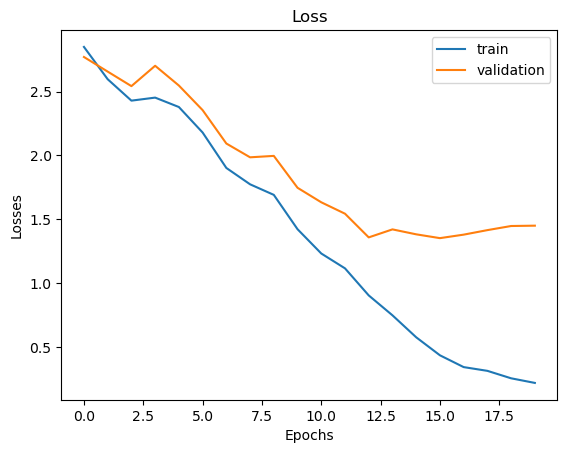

In [30]:
plt.title("Loss")
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

### plot the accuracy

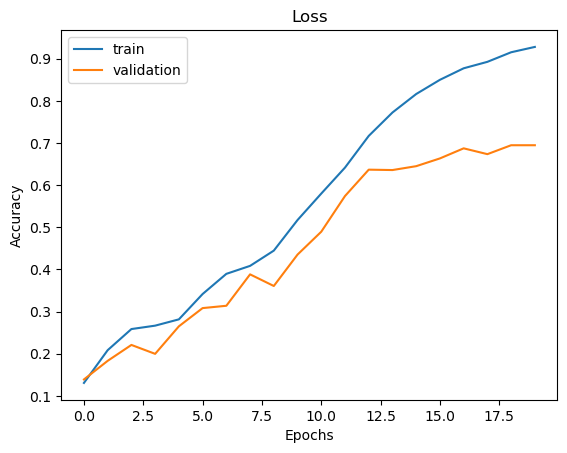

In [31]:
plt.title("Loss")
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Embedding with Gated Recurrent Units

In [32]:
# apply modelcheckpoint and earlystopping in the model  when fitted the model
checkpoint = ModelCheckpoint("/kaggle/working/",monitor='val_loss',save_best_only=True,mode='min',verbose=0)
earlystopping= EarlyStopping(monitor="val_loss",patience=4,restore_best_weights=True,verbose=1)

In [33]:
model2 = Sequential()
model2.add(Embedding(vocab_size,300,input_length=max_seq_len))
model2.add(SpatialDropout1D(0.2))
model2.add(GRU(128, return_sequences = False))
model2.add(Flatten())
model2.add(Dense(no_of_categories,activation='softmax'))

### compile the model

In [34]:
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 300)          17877600  
                                                                 
 spatial_dropout1d (SpatialD  (None, 150, 300)         0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
Total params: 18,045,300
Trainable params: 18,045,300
Non-trainable params: 0
__________________________________________

### fit the model

In [35]:
history2 = model2.fit(X_train,y_train,epochs=10,verbose=1,validation_split=0.1,callbacks=[checkpoint,earlystopping])

Epoch 1/10
306/306 [==============================] - 36s 110ms/step - loss: 2.8402 - accuracy: 0.1284 - val_loss: 2.7113 - val_accuracy: 0.1555
Epoch 2/10
306/306 [==============================] - 21s 67ms/step - loss: 2.3278 - accuracy: 0.2832 - val_loss: 2.0431 - val_accuracy: 0.3855
Epoch 3/10
306/306 [==============================] - 16s 51ms/step - loss: 1.3209 - accuracy: 0.5960 - val_loss: 1.1840 - val_accuracy: 0.6477
Epoch 4/10
306/306 [==============================] - 15s 49ms/step - loss: 0.6306 - accuracy: 0.8102 - val_loss: 1.0006 - val_accuracy: 0.7148
Epoch 5/10
306/306 [==============================] - 12s 39ms/step - loss: 0.3455 - accuracy: 0.8952 - val_loss: 0.9011 - val_accuracy: 0.7470
Epoch 6/10
306/306 [==============================] - 8s 25ms/step - loss: 0.2090 - accuracy: 0.9353 - val_loss: 0.9050 - val_accuracy: 0.7718
Epoch 7/10
306/306 [==============================] - 7s 21ms/step - loss: 0.1563 - accuracy: 0.9511 - val_loss: 0.9652 - val_accuracy: 

In [36]:
# saved the GRU mode
save_model(model2,"Model_GRU.h5")

In [37]:
# load the model
model21 = load_model("/kaggle/working/Model_GRU.h5")

### Evaluate the model

In [38]:

accr2 = model21.evaluate(X_test, y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr2[0], accr2[1]))

85/85 [==============================] - 1s 7ms/step - loss: 0.9526 - accuracy: 0.7369
Test Set: 
 Loss: 0.953
 Accuracy: 0.737


### plot the loss

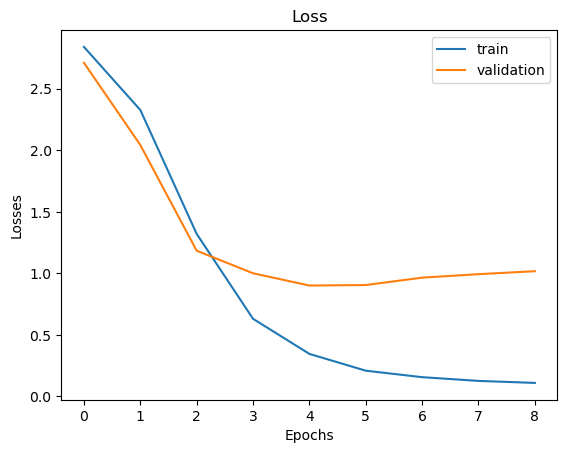

In [39]:
plt.title("Loss")
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

### plot the accuracy

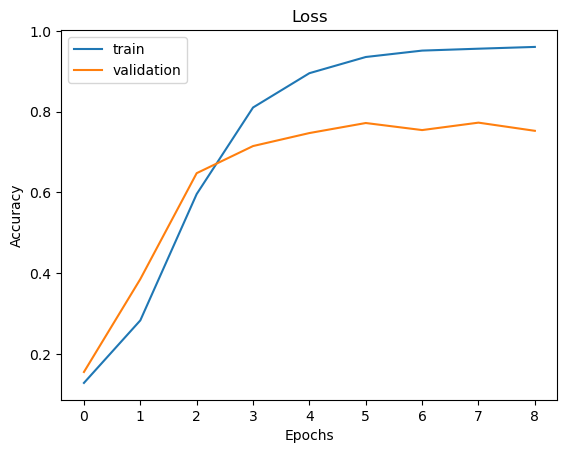

In [40]:
plt.title("Loss")
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()